In [14]:
import pandas as pd
import numpy as np
import operator
import xgboost as xgb
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from operator import add
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
color = sns.color_palette()
%matplotlib inline

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 16:32:34.717268. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
train = pd.read_csv('train.csv',sep=';')
test = pd.read_csv('test.csv',sep=';')

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 15:46:21.410564. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
train_y = train['cardio'].values

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 15:46:24.523564. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
train1000 = train[0:1000]
train_y1000 = train_y[0:1000]

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 15:46:59.136107. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [24]:
train.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000


In [37]:
train['age_years']  = train['age'] // 365 // 3

In [61]:
train[train['ap_hi']<0]['ap_hi']

4607    -100
16021   -115
20536   -100
23988   -140
25240   -120
35040   -150
46627   -120
Name: ap_hi, dtype: int64

In [45]:
train.head(30)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [10]:
train.groupby(['gender'])['cardio'].mean()

gender
1    0.496727
2    0.505231
Name: cardio, dtype: float64

In [63]:
train.groupby(['gender'])['height'].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [41]:
train.groupby(['alco'])['cardio'].mean()

alco
0    0.500574
1    0.484325
Name: cardio, dtype: float64

In [44]:
train.groupby(['active'])['cardio'].mean()

active
0    0.535774
1    0.490891
Name: cardio, dtype: float64

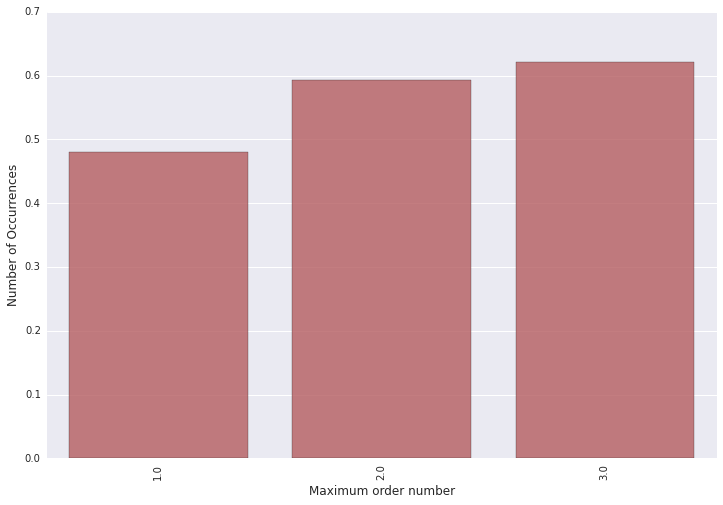

In [40]:
cnt_srs = train.groupby("gluc")["cardio"].aggregate(np.mean).reset_index()

plt.figure(figsize=(12,8))
sns.barplot([f[0] for f in cnt_srs.values], [f[1] for f in cnt_srs.values], alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [33]:
cnt_srs = train.groupby("age_years")["cardio"].aggregate(np.mean).reset_index()
[f[1] for f in cnt_srs.values]

[0.0,
 0.0,
 0.24269662921348314,
 0.21454993834771888,
 0.29637414608512874,
 0.29901269393511987,
 0.36632200886262922,
 0.35931307793923384,
 0.40776233828461905,
 0.39323076923076922,
 0.48202093764223941,
 0.4561016013252347,
 0.42405618964003511,
 0.38805970149253732,
 0.47298099762470308,
 0.46386093321134492,
 0.50413650465356774,
 0.4854368932038835,
 0.55309396485867079,
 0.53534793457166618,
 0.56755290287574611,
 0.55705485479612793,
 0.61493288590604023,
 0.58374999999999999,
 0.68071847507331373,
 0.67075943610732147,
 0.72843567251461994,
 0.70919067215363507]

In [5]:
np.mean(train_y1000)

0.50700000000000001

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 15:47:42.164264. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
tsne = TSNE(n_components=2, random_state=42)
d2 = tsne.fit_transform(train1000) 

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 18:10:20.485441. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
d2

array([[-12.19473922,   2.7872713 ],
       [ 11.94497056,  -7.28153884],
       [  3.98740949, -18.50310822],
       ..., 
       [-19.42958183,   3.02041602],
       [ -5.06306352,   9.88737287],
       [ 10.01694826, -16.50160008]])

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 18:10:29.195282. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


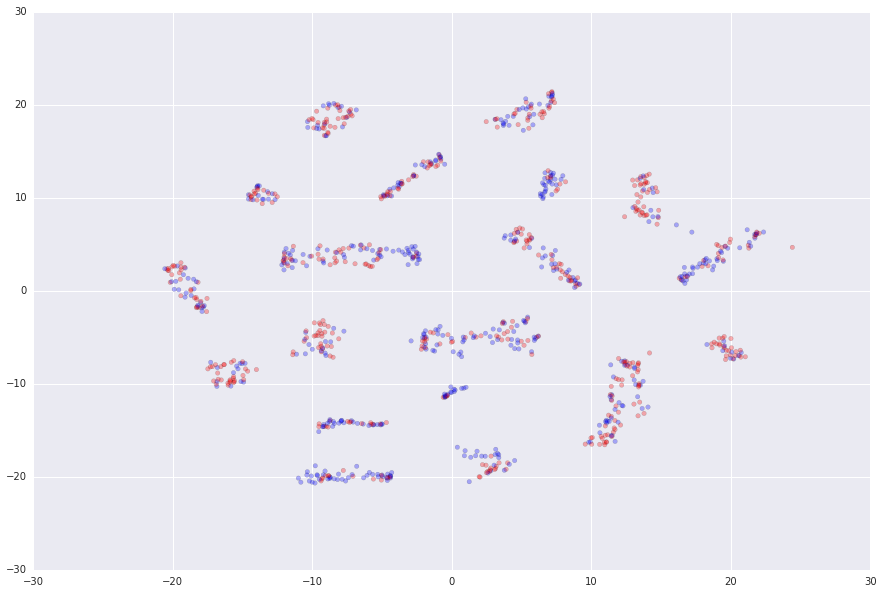

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 18:10:35.568337. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
colors = ['blue','red']
plt.figure(figsize=(15, 10))
plt.scatter([d[0] for d in d2], [d[1] for d in d2],  alpha=0.3, c= [colors[a] for a in train_y1000])

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Library/Python/2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-

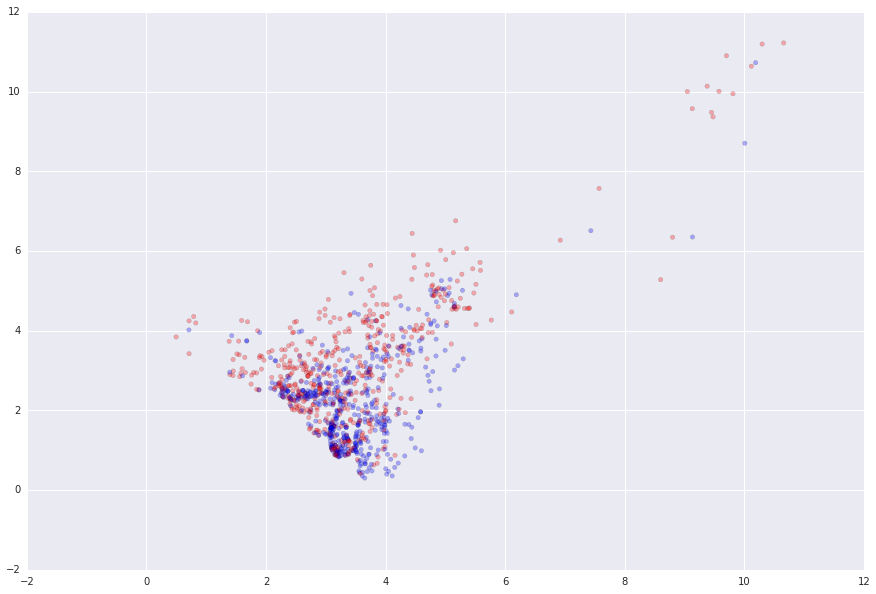

/Library/Python/2.7/site-packages/simplejson-3.5.3-py2.7-macosx-10.10-intel.egg/simplejson/encoder.py:269: DeprecationWarning: Interpreting naive datetime as local 2017-07-07 16:33:47.109948. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
n_clusters = 100
cols = ['ap_lo','ap_hi','weight','height','gender','cholesterol', 'gluc']
for col in cols:
    scale = StandardScaler()
    train1000[col] = scale.fit_transform(train1000[col])
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000000).fit(train1000[cols])
res = kmeans.transform(train1000[cols])

colors = ['blue','red']
plt.figure(figsize=(15, 10))
plt.scatter([d[0] for d in res], [d[1] for d in res],  alpha=0.3, c= [colors[a] for a in train_y1000])


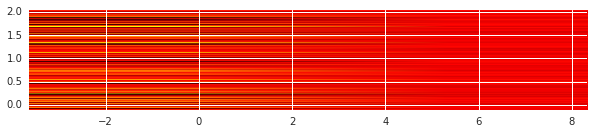

In [8]:
extent=[np.min(train[2]),np.max(train[2]),np.min(train[3]),np.max(train[3])]
plt.figure(figsize=(10, 10))
plt.imshow(train[[2,3]].values, cmap='hot', extent=extent)
plt.show()

In [16]:
a[0]

array([ 0.69458682,  0.98025399,  0.19625699,  0.65543231,  0.51373535])